In [1]:
import numpy as np
import scipy
from scipy import signal
import mne
import glob
from sklearn.decomposition import PCA
import csv

#### Calculate the band power over a time series

In [2]:
# Calculate the band power over a time series

def bandpower(x, fs, fmin, fmax):
    """
    Returns the band power over the specified frequency interval
    
    x - input time series (1D array)
    fs - sampling frequency
    fmin - min frequency
    fmax - max frequency
    """
    
    f, Pxx = signal.periodogram(x, fs=fs)
    ind_min = scipy.argmax(f > fmin) - 1
    ind_max = scipy.argmax(f > fmax) - 1
    return scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

#### Reduce the dimensionality of an array to the specified number of components

In [3]:
def pca(array, n_components=5, get_pca_object=False):
    pca = PCA(n_components=n_components)
    if not get_pca_object:
        return pca.fit_transform(array)
    return pca.fit_transform(array), pca

#### This will be used for logging

In [4]:
def log_result(file, name, accuracy, patients_correct, patients_total, set_name, channels, notes):
    """
    Log the result of an experiment in a csv file with the following information:
        experiment name, accuracy (over all repetitions), number of correct patients/total number of patients, 
        dataset name, selected channels, notes
    """
    writer = csv.writer(file)
    writer.writerow([name, str(accuracy*100) + '%', ' ' + str(patients_correct) + '/' + str(patients_total), set_name, channels, notes])
        

# Apply bandpower to datasets

In [5]:
def get_datasets(patient_type_location, recording_type_expression):
    """
    Returns relevant datasets (f.e. all right-hand recordings of patients with pain) as a list of np arrays
    First parameter should be a regex for location, second parameter should be a regex for dataset type
    E.g. if right-hand movement datasets of patients with pain are in /data/pp/ and their file names contain '_RH_'
    then patient_type_location=/data/pp/ and recording_type_expression='_RH_'
    """
    
    # Find locations of matching dataset files
    if recording_type_expression != l_new:
        sets_locations = glob.glob(patient_type_location + recording_type_expression + suffix)
    else:
        # For the newer (PDP/PP) dataset we had to use a separate expression with includes the file extension
        sets_locations = glob.glob(patient_type_location + recording_type_expression)
    
    sets = []
    for path in sets_locations: 
        sets.append(mne.io.read_epochs_eeglab(path))
        
    return np.array(np.array([(patient._data) for patient in sets]))

In [6]:
# Calculate bandpower for all channels for a patient
bands = [(4, 8), (8, 13), (13, 30)]
time_series_index = range(1250)[0:1250]

def channels_bandpower(channels, bands, fs=250):
    b = bandpower
    return np.array(list(map( lambda arr: [b(arr[time_series_index], fs, band[0], band[1]) for band in bands], channels)))

#### Define dataset locations and expressions

In [7]:
root = './../../../'
suffix = '*.set'

# Old (PP/PNP datasets)
location_healthy = root + 'data/raw/HV/*/'
location_pain = root + 'data/raw/PP/*/'
location_nopain = root + 'data/raw/PnP/*/'

# New (PDP/PNP datasets)
location_pwp = root + 'data_new/raw/PwP/*/'
location_pdp = root + 'data_new/raw/PdP/*/'
location_pnp = root + 'data_new/raw/PnP/*/'

rh = '*_RH*'
lh = '*_LH*'
l_new = '*_L.set'   # NO SUFFIX
l_old = '*_L_*'


# As an example, get paths of all PP/PNP datasets from right-hand movements
sets_healthy_rh = glob.glob(location_pain + rh + suffix)
sets_healthy_rh

['./../../../data/raw/PP\\PP1\\PP1_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP10\\PP10_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP11\\PP11_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP2\\PP2_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP3\\PP3_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP4\\PP4_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP5\\PP5_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP6\\PP6_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP7\\PP7_F1_RH_Removed_ICA.set',
 './../../../data/raw/PP\\PP9\\PP9_F1_RH_Removed_ICA.set']

#### Now read the chosen datasets

In [32]:
pp_rh_raw = get_datasets(location_pain, rh)
pnp_rh_raw = get_datasets(location_nopain, rh)

Extracting parameters from ./../../../data/raw/PP\PP1\PP1_F1_RH_Removed_ICA.set...
57 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP10\PP10_F1_RH_Removed_ICA.set...
57 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP11\PP11_F1_RH_Removed_ICA.set...
59 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP2\PP2_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP3\PP3_F1_RH_Removed_ICA.set...
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP4\PP4_F1_RH_Removed_ICA.set...


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP5\PP5_F1_RH_Removed_ICA.set...
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP6\PP6_F1_RH_Removed_ICA.set...
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../../data/raw/PP\PP7\PP7_F1_RH_Removed_ICA.set...
52 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PP\PP9\PP9_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PnP\PnP1\PnP1_F1_RH_Removed_ICA.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PnP\PnP2\PnP2_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../../data/raw/PnP\PnP3\PnP3_F1_RH_Removed_ICA.set...
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PnP\PnP4\PnP4_F1_RH_Removed_ICA.set...
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../../data/raw/PnP\PnP5\PnP5_F1_RH_Removed_ICA.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PnP\PnP6\PnP6_F1_RH_Removed_ICA.set...
55 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../../data/raw/PnP\PnP7\PnP7_F01_RH_Removed_ICA.set...
58 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Extracting parameters from ./../../../data/raw/PnP\PnP8\PnP8_F1_RH_Removed_ICA.set...
53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))
<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


Extracting parameters from ./../../../data/raw/PnP\PnP9\PnP9_F1_RH_Removed_ICA.set...
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


<ipython-input-5-916861aa92ff>:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  sets.append(mne.io.read_epochs_eeglab(path))


In [33]:
# The entry for a patient should have shape (n_repetitions, n_channels, n_readings)
pp_rh_raw[4].shape

(51, 61, 1250)

#### Apply the bandpower 

In [34]:
pp_rh_bp = np.array([np.array([channels_bandpower(repetition, bands) for repetition in patient]) for patient in pp_rh_raw])
pnp_rh_bp = np.array([np.array([channels_bandpower(repetition, bands) for repetition in patient]) for patient in pnp_rh_raw])

In [35]:
# Get the total number of repetitions for each class
pp_count = np.vstack(pp_rh_bp).shape[0]
pnp_count = np.vstack(pnp_rh_bp).shape[0]
pnp_count

473

In [36]:
pnp_rh_bp.shape

(9,)

#### Concatenate the two classes

In [37]:
pp_and_pnp_bp = np.concatenate((pp_rh_bp, pnp_rh_bp))
pp_and_pnp_bp.shape

(19,)

#### Set some patients aside for testing

In [16]:
def test_setup(test_index, total_size):
    """
    Returns a pair consisting of boolean (True is test patient is PP) and test label
    Labels are 1 for pain, 0 for no pain
    """
    
    test_is_pp = test_index < len(pp_rh_bp)
    test_label = 1 if test_is_pp else 0
    return test_is_pp, test_label


def get_train_test(data, test_index):
    """
    Splits into train and test sets based on the index of the test patient
    Returns pair of test and train
    """
    
    return data[test_index], np.delete(data, test_index)


def get_pp_pnp_length(pp_count, pnp_count, test_count, test_is_pp):
    """ Returns pair of the lengths of PP train data and respectively PNP train data """
    
    pp_train_len = pp_count if not test_is_pp else pp_count - test_count
    pnp_train_len = pnp_count if test_is_pp else pnp_count - test_count
    return pp_train_len, pnp_train_len


def ravel_all_trials(data, channels):
    """
    Ravel first dimention so that trials from all patients are treated separately; select channels
    """
    return np.array(list(map(np.ravel, data[:, channels, :])))

In [17]:
test_index = 4

test_is_pp, test_label = test_setup(test_index, len(pp_rh_bp))
test_label

1

In [18]:
test_p, train_p = get_train_test(pp_and_pnp_bp, test_index)
test_p.shape

(52, 61, 3)

In [19]:
train_p_separated = np.vstack(train_p)
train_p_separated.shape

(948, 61, 3)

In [20]:
pp_train_len, pnp_train_len = get_pp_pnp_length(pp_count, pnp_count, len(test_p), test_is_pp)
pp_train_len

476

Define a multiplier for all features - if 1, then input data is unaltered

In [21]:
mul = 1

In [20]:
selected_channels = [10, 11]

In [21]:
train = ravel_all_trials(train_p_separated, selected_channels) * mul
train.shape

(589, 6)

In [22]:
test = ravel_all_trials(test_p, selected_channels) * mul
test.shape

(59, 6)

#### Define the number of PCA components we will use

In [26]:
n_components = 3

In [24]:
pca(train, n_components).shape

(589, 3)

Some analysis of the PCA components

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [31]:
channels_to_plot = list(range(61))

arr_pp, components_pp = pca(ravel_all_trials(np.vstack(pp_rh_bp), channels_to_plot), n_components, get_pca_object=True)
arr_pnp, components_pnp = pca(ravel_all_trials(np.vstack(pnp_rh_bp), channels_to_plot), n_components, get_pca_object=True)

arr_all, components_all = pca(ravel_all_trials(np.vstack(np.concatenate((pp_rh_bp, pnp_rh_bp))), channels_to_plot), n_components, get_pca_object=True)

components_all.components_.shape

(3, 183)

In [32]:
plot_mul = 10**10

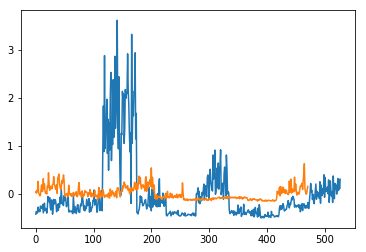

In [33]:
plt.plot(arr_pp[:,0]*plot_mul)
plt.plot(arr_pnp[:,0]*plot_mul)

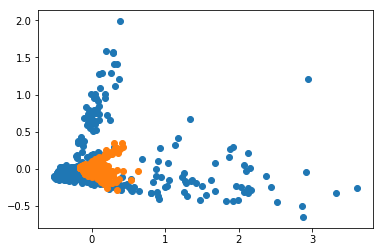

In [34]:
plt.scatter(arr_pp[:,0]*plot_mul,arr_pp[:,1]*plot_mul)
plt.scatter(arr_pnp[:,0]*plot_mul,arr_pnp[:,1]*plot_mul)
#plt.xlim((-0.18, 0.1))
#plt.ylim((-0.2, 0.2))

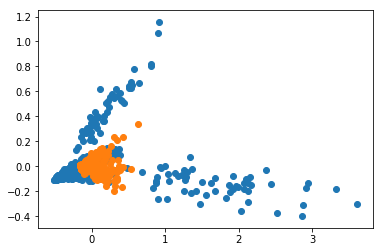

In [35]:
plt.scatter(arr_pp[:,0]*plot_mul,arr_pp[:,2]*plot_mul)
plt.scatter(arr_pnp[:,0]*plot_mul,arr_pnp[:,2]*plot_mul)
#plt.xlim((-0.12, 0.1))
#plt.ylim((-0.15, 0.2))

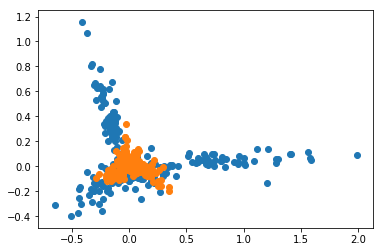

In [36]:
plt.scatter(arr_pp[:,1]*plot_mul,arr_pp[:,2]*plot_mul)
plt.scatter(arr_pnp[:,1]*plot_mul,arr_pnp[:,2]*plot_mul)
#plt.xlim((-0.12, 0.1))
#plt.ylim((-0.15, 0.2))

In [37]:
np.mean(components_pp.components_[2])

0.0199456507636704

In [38]:
plt_vmin = 0
plt_vmax = 0.2

In [39]:
band_names = ['theta', 'alpha', 'beta']
channel_names = ['Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'CPz', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Pz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'AFz', 'AF3', 'AF4', 'AF7', 'AF8', 'Fp1', 'FP2', 'POz', 'PO3', 'PO4', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'Iz']

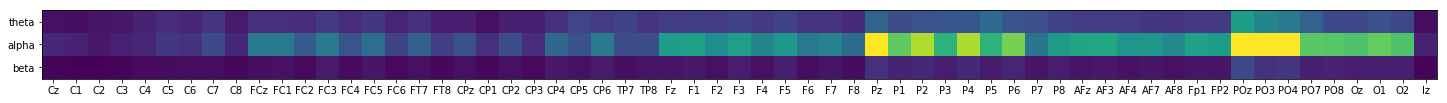

In [40]:
plt.figure(figsize=(25, 10))
plt.xticks(channels_to_plot, labels=channel_names)
plt.yticks([0,1,2], labels=band_names)
plt.imshow(np.abs([components_all.components_[0][::3], components_all.components_[0][1::3], components_all.components_[0][2::3]]), vmin=plt_vmin, vmax=plt_vmax)

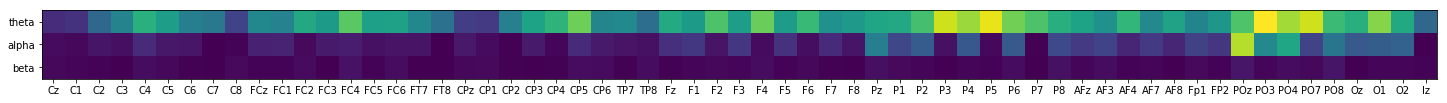

In [41]:
plt.figure(figsize=(25, 10))
plt.xticks(channels_to_plot, labels=channel_names)
plt.yticks([0,1,2], labels=band_names)
plt.imshow(np.abs([components_all.components_[1][::3], components_all.components_[1][1::3], components_all.components_[1][2::3]]), vmin=plt_vmin, vmax=plt_vmax)

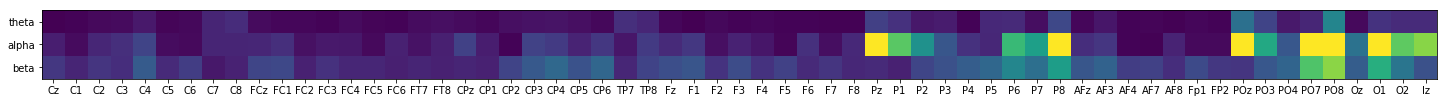

In [42]:
plt.figure(figsize=(25, 10))
plt.xticks(channels_to_plot, labels=channel_names)
plt.yticks([0,1,2], labels=band_names)
plt.imshow(np.abs([components_all.components_[2][::3], components_all.components_[2][1::3], components_all.components_[2][2::3]]), vmin=plt_vmin, vmax=plt_vmax)

#### Generate labels

In [27]:
labels = [1] * pp_train_len + [0] * pnp_train_len
test_labels = [test_label] * len(test)

#### It's time to learn

In [38]:
from sklearn import neighbors, svm
from sklearn.model_selection import train_test_split

In [29]:
# Try a simple KNN classification

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.05)
knn.fit(x_train, y_train)
knn.score(x_train, y_train)
knn.score(x_test, y_test)

0.8666666666666667

In [30]:
knn.score(test, [test_label]*len(test))

0.22033898305084745

In [31]:
np.count_nonzero(knn.predict(test) == test_labels)/len(test)

0.22033898305084745

## Classification with cross validation

### KNN

In [39]:
def classify_knn_with_xvalid(data_pp_bp, data_pnp_bp, n_neighbours, selected_channels, test_index, mul, verbose=True):
    """
    Leaves out patient at test_index and trains a KNN classifier on all other patients
    Validates classifier on patient at test_index
    Returns accuracy over all repetitions for the test patient
    """
    
    data_bp = np.concatenate((data_pp_bp, data_pnp_bp))
    
    test_is_pp, test_label = test_setup(test_index, len(data_pp_bp))
    test_p, train_p = get_train_test(data_bp, test_index)
    train_p_separated = np.vstack(train_p)
    pp_train_len, pnp_train_len = get_pp_pnp_length(pp_count, pnp_count, len(test_p), test_is_pp)
    
    # Apply PCA for dimensionality reduction as defined above
    train = pca(ravel_all_trials(train_p_separated, selected_channels) * mul, n_components=n_components)
    test = pca(ravel_all_trials(test_p, selected_channels) * mul, n_components=n_components)
    
    labels = [1] * pp_train_len + [0] * pnp_train_len
    test_labels = [test_label] * len(test)
    
    if verbose:
        print('Test index', test_index, 'Testing on patient with', len(test), 'repetitions.')
    
    clas = neighbors.KNeighborsClassifier(n_neighbors=n_neighbours)
    clas.fit(train, labels)
    train_acc = clas.score(train, labels)
    test_acc = clas.score(test, test_labels)
    
    if verbose:
        print('Train score:', train_acc, '  Test score:', test_acc)
    
    return test_acc
    
    

In [24]:
classify_knn_with_xvalid(pp_rh_bp, pnp_rh_bp, 23, [36, 38], 2, 10000000000000)

NameError: name 'n_components' is not defined

#### Cross validate over the whole dataset

In [40]:
total_score = 0
patients_correct = 0
accs = []
for i in range(len(pp_and_pnp_bp)):
    score = classify_knn_with_xvalid(pp_rh_bp, pnp_rh_bp, 1, [42], i, mul)
    accs.append(score)
    total_score += score
    if score > 0.5:
        patients_correct += 1
    
print('Overall accuracy', total_score/len(pp_and_pnp_bp))
print('Correctly labeled', patients_correct, 'out of', len(pp_and_pnp_bp))
print('std', np.std(accs))

Test index 0 Testing on patient with 57 repetitions.
Train score: 1.0   Test score: 0.45614035087719296
Test index 1 Testing on patient with 57 repetitions.
Train score: 1.0   Test score: 0.5087719298245614
Test index 2 Testing on patient with 59 repetitions.
Train score: 1.0   Test score: 0.4915254237288136
Test index 3 Testing on patient with 54 repetitions.
Train score: 1.0   Test score: 0.7037037037037037
Test index 4 Testing on patient with 51 repetitions.
Train score: 1.0   Test score: 0.3333333333333333
Test index 5 Testing on patient with 58 repetitions.
Train score: 1.0   Test score: 0.46551724137931033
Test index 6 Testing on patient with 56 repetitions.
Train score: 1.0   Test score: 0.42857142857142855
Test index 7 Testing on patient with 32 repetitions.
Train score: 1.0   Test score: 0.40625
Test index 8 Testing on patient with 52 repetitions.
Train score: 1.0   Test score: 0.5384615384615384
Test index 9 Testing on patient with 54 repetitions.
Train score: 1.0   Test scor

#### Cross validate over multiple channels

We use this to check which channels yield better results

In [71]:
# Log results in a csv file
file = open('all_results/bandpower_pca_knn_results.csv', 'a', newline='')
name = 'Bandpower + PCA + KNN'
notes = 'freq bands 4-8,8-13,13-30, k='
notes_c = ', n_components='

previous_channels = [42]
k = 1

max_acc = {'index': 0, 'value': 0}
for channel in range(61):    
    total_score = 0
    correct_patients = 0
    for i in range(len(pp_and_pnp_bp)):
        score = classify_knn_with_xvalid(pp_rh_bp, pnp_rh_bp, k, previous_channels + [channel], i, mul, verbose=False)
        total_score += score
        if score > 0.5:
            correct_patients += 1
        
    avg_score = total_score/len(pp_and_pnp_bp)
    print(channel, avg_score, correct_patients)
    
    log_result(file, name, avg_score, correct_patients, len(pp_and_pnp_bp), 'RH', str(previous_channels + [channel]), notes + str(k) + notes_c + str(n_components))
    
    if avg_score > max_acc['value']:
        max_acc['index'] = channel
        max_acc['value'] = avg_score
        
file.close()
        
print('Max accuracy:', max_acc['index'], max_acc['value'])

0 0.5111021719298109 7
1 0.5158619477635346 7
2 0.5213870195476474 7
3 0.5424761845927586 10
4 0.5075884523425922 9
5 0.4345336139659855 8
6 0.4328427663510304 9
7 0.4709121398004717 9
8 0.4607955835571042 6
9 0.44709525041272363 6
10 0.496164105027943 8
11 0.4898097191486595 9
12 0.41969058971968237 6
13 0.4821553715771834 6
14 0.3974077723171117 3
15 0.41727740578184214 5
16 0.4315060042067785 4
17 0.3976346592527337 7
18 0.4733982136712487 9
19 0.5094899375450033 8
20 0.4350060213143883 5
21 0.437489892016679 9
22 0.48231648678881944 9
23 0.431440330598427 8
24 0.4272127604270761 9
25 0.4199236079275012 3
26 0.503465864790067 8
27 0.3712939999007045 6
28 0.37564228508682973 6
29 0.3949663232972068 5
30 0.41443594456022337 6
31 0.3931755262101615 5
32 0.406703394233204 7
33 0.3919701081862276 7
34 0.4086907160221717 5
35 0.4174122130977443 8
36 0.4330331049976084 10
37 0.5042014203857503 10
38 0.5261574547920786 11
39 0.43605794807629855 8
40 0.4115137926976091 8
41 0.405513107374286

### Cross validate over multiple n_neighbours

In [72]:
file = open('all_results/bandpower_pca_knn_results.csv', 'a', newline='')
name = 'Bandpower + PCA + KNN'
notes = 'freq bands 4-8,8-13,13-30, k='
notes_c = ', n_components='

channels = [42]

max_acc = {'index': 0, 'value': 0}
for n_neighbours in range(1, 50, 3):    
    total_score = 0
    correct_patients = 0
    for i in range(len(pp_and_pnp_bp)):
        score = classify_knn_with_xvalid(pp_rh_bp, pnp_rh_bp, n_neighbours, channels, i, mul, verbose=False)
        total_score += score
        if score > 0.5:
            correct_patients += 1
        
    avg_score = total_score/len(pp_and_pnp_bp)
    print(n_neighbours, avg_score, correct_patients)
    
    log_result(file, name, avg_score, correct_patients, len(pp_and_pnp_bp), 'RH', str(channels), notes + str(n_neighbours) + notes_c + str(n_components))
    
    if avg_score > max_acc['value']:
        max_acc['index'] = n_neighbours
        max_acc['value'] = avg_score
        
file.close()
        
print('Max accuracy:', max_acc['index'], max_acc['value'])

1 0.5465326229219931 9
4 0.4983808658728607 5
7 0.4185303253559405 10
10 0.39452572332041685 10
13 0.43306806511943935 10
16 0.425365808179489 10
19 0.4346453182278237 10
22 0.4323314748333765 10
25 0.43987678164978056 10
28 0.4234724373415031 10
31 0.4308814515703253 10
34 0.42646846894434576 10
37 0.43656641066409757 10
40 0.4252752999927343 10
43 0.4366048245705701 10
46 0.42693563028348425 10
49 0.4306455630100374 10
Max accuracy: 1 0.5465326229219931


## SVM

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
pca_components = 3

In [41]:
def classify_nusvm_with_xvalid(data_pp_bp, data_pnp_bp, nu, selected_channels, test_index, mul, verbose=True):
    """
    Leaves out patient at test_index and trains a linear SVM classifier on all other patients
    Validates classifier on patient at test_index
    Returns accuracy over all repetitions for the test patient
    """
    
    data_bp = np.concatenate((data_pp_bp, data_pnp_bp))
    
    test_is_pp, test_label = test_setup(test_index, len(data_pp_bp))
    test_p, train_p = get_train_test(data_bp, test_index)
    train_p_separated = np.vstack(train_p)
    pp_train_len, pnp_train_len = get_pp_pnp_length(pp_count, pnp_count, len(test_p), test_is_pp)
    
    train = pca(ravel_all_trials(train_p_separated, selected_channels) * mul, n_components=pca_components)
    test = pca(ravel_all_trials(test_p, selected_channels) * mul, n_components=pca_components)
    
    labels = [1] * pp_train_len + [0] * pnp_train_len
    test_labels = [test_label] * len(test)
    
    if verbose:
        print('Test index', test_index, 'Preparing to classify set of', pp_train_len, 'PP and', pnp_train_len, 'PNP.')
    
    clas = svm.NuSVC(nu=nu, kernel='linear')
    clas.fit(train, labels)
    train_acc = clas.score(train, labels)
    test_acc = clas.score(test, test_labels)
    
    if verbose:
        print('Train score:', train_acc, '  Test score:', test_acc)
    
    return test_acc
    

In [42]:
total_score = 0
patients_correct = 0
accs = []
for i in range(len(pp_and_pnp_bp)):
    score = classify_nusvm_with_xvalid(pp_rh_bp, pnp_rh_bp, 0.8585, [0, 1, 1, 2, 3, 3, 5, 12, 13, 23, 30, 52, 57], i, mul)
    accs.append(score)
    total_score += score
    if score > 0.5:
        patients_correct += 1
    

print(total_score/len(pp_and_pnp_bp))
print('Correctly labeled', patients_correct, 'out of', len(pp_and_pnp_bp))
print('std', np.std(accs))

Test index 0 Preparing to classify set of 473 PP and 473 PNP.
Train score: 0.6807610993657506   Test score: 0.9649122807017544
Test index 1 Preparing to classify set of 473 PP and 473 PNP.
Train score: 0.7071881606765328   Test score: 1.0
Test index 2 Preparing to classify set of 471 PP and 473 PNP.
Train score: 0.6917372881355932   Test score: 0.5254237288135594
Test index 3 Preparing to classify set of 476 PP and 473 PNP.
Train score: 0.6891464699683878   Test score: 0.9814814814814815
Test index 4 Preparing to classify set of 479 PP and 473 PNP.
Train score: 0.7121848739495799   Test score: 1.0
Test index 5 Preparing to classify set of 472 PP and 473 PNP.
Train score: 0.6835978835978836   Test score: 0.9827586206896551
Test index 6 Preparing to classify set of 474 PP and 473 PNP.
Train score: 0.7286166842661035   Test score: 1.0
Test index 7 Preparing to classify set of 498 PP and 473 PNP.
Train score: 0.713697219361483   Test score: 1.0
Test index 8 Preparing to classify set of 478

In [49]:
mul = 10**0

In [55]:
file = open('all_results/bandpower_pca_svm_results_pdp_legs.csv', 'a', newline='')
n_components = pca_components
name = 'Bandpower + PCA + SVM'
notes = 'freq bands 4-8,8-13,13-30, nu='
notes_c = ', n_components='

previous_channels=[8, 11, 17, 17, 18, 19]
nu = 0.601

max_acc = {'index': 0, 'value': 0}
for channel in range(48):    
    total_score = 0
    correct_patients = 0
    for i in range(len(pp_and_pnp_bp)):
        score = classify_nusvm_with_xvalid(pp_rh_bp, pnp_rh_bp, nu, previous_channels + [channel], i, mul, verbose=False)
        total_score += score
        if score > 0.5:
            correct_patients += 1
        
    avg_score = total_score/len(pp_and_pnp_bp)
    print(channel, avg_score, correct_patients)
    
    log_result(file, name, avg_score, correct_patients, len(pp_and_pnp_bp), 'L', str(previous_channels + [channel]), notes + str(nu) + notes_c + str(n_components))
    
    if avg_score > max_acc['value']:
        max_acc['index'] = channel
        max_acc['value'] = avg_score
        

file.close()
        
print('Max accuracy:', max_acc['index'], max_acc['value'])

0 0.7573651119395247 10
1 0.6575251429306589 8
2 0.6777518800210593 8
3 0.6038126448418598 7
4 0.6229646664169411 8
5 0.7204132720948065 9
6 0.719173510339508 9
7 0.8024851596762836 10
8 0.806867588598558 10
9 0.5835380942941157 7
10 0.6514209167914936 11
11 0.7370634486189793 10
12 0.8098772097166388 10
13 0.8083891144785436 10
14 0.5708169804969538 7
15 0.6892310514344412 9
16 0.426466633648837 5
17 0.8170373416849777 11
18 0.8098904372298663 10
19 0.8095884090111714 11
20 0.8081003137730761 10
21 0.8012924041685564 10
22 0.7142423725738475 10
23 0.7138521659395879 9
24 0.6064821980477645 8
25 0.7963477022393913 11
26 0.7973341760496088 10
27 0.8050429017244362 10
28 0.8037061382054692 10
29 0.79769018613131 11
30 0.7964085372507911 11
31 0.7846289661621954 10
32 0.6227305648558994 8
33 0.7696309653249144 10
34 0.7709752172118364 10
35 0.7222459178963788 10
36 0.7997855257043481 11
37 0.7970823557424063 10
38 0.8044060636310859 10
39 0.7857027217862038 11
40 0.695416687048043 9
41 0.

#### Cross validate over multiple nu values

In [58]:
file = open('all_results/bandpower_pca_svm_results_pdp_legs.csv', 'a', newline='')
n_components = pca_components
name = 'Bandpower + PCA + SVM'
notes = 'freq bands 4-8,8-13,13-30 nu='
notes_c = ', n_components='

channels = [8, 11, 17, 17, 18, 19]

max_acc = {'index': 0, 'value': 0}
for param in np.arange(0.59, 0.61, 0.0001):    
    total_score = 0
    correct_patients = 0
    for i in range(len(pp_and_pnp_bp)):
        score = classify_nusvm_with_xvalid(pp_rh_bp, pnp_rh_bp, param, channels, i, mul, verbose=False)
        total_score += score
        if score > 0.5:
            correct_patients += 1
        
    avg_score = total_score/len(pp_and_pnp_bp)
    print(param, avg_score, correct_patients)
    
    log_result(file, name, avg_score, correct_patients, len(pp_and_pnp_bp), 'L', str(channels), notes + str(param) + notes_c + str(n_components))
    
    if avg_score > max_acc['value']:
        max_acc['index'] = param
        max_acc['value'] = avg_score

file.close()
        
print('Max accuracy:', max_acc['index'], max_acc['value'])

0.59 0.7169508811155034 10
0.5901 0.72736754778217 10
0.5902 0.72736754778217 10
0.5902999999999999 0.7303978508124732 10
0.5903999999999999 0.7303978508124732 10
0.5904999999999999 0.7303978508124732 10
0.5905999999999999 0.7303978508124732 10
0.5906999999999999 0.7303978508124732 10
0.5907999999999999 0.7303978508124732 10
0.5908999999999999 0.6442396587220777 8
0.5909999999999999 0.6442396587220777 8
0.5910999999999998 0.6442396587220777 8
0.5911999999999998 0.6442396587220777 8
0.5912999999999998 0.6635848968173158 7
0.5913999999999998 0.6635848968173158 7
0.5914999999999998 0.6635848968173158 7
0.5915999999999998 0.6635848968173158 7
0.5916999999999998 0.6635848968173158 7
0.5917999999999998 0.6635848968173158 7
0.5918999999999998 0.6635848968173158 7
0.5919999999999997 0.6552515634839824 7
0.5920999999999997 0.6552515634839824 7
0.5921999999999997 0.6552515634839824 7
0.5922999999999997 0.6640234933085437 7
0.5923999999999997 0.6640234933085437 7
0.5924999999999997 0.664023493308

In [45]:
file.close()